# Emulating NEB Tm Calculator

The purpose of this notebook is to attempt to replicate the behaviour of the [NEB Tm Calculator](https://tmcalculator.neb.com/#!/batch) version 1.16.5.

The NEB Tm Calculator comes with four default primers. We use these in batch mode with standard Taq polymerase and standard buffer.
Standard primer conentration.

## Settings:

![](settings1.png)

## Results:

![](settings2.png)

The results were extracted to a markdown table:

| Name  | Sequence                 | NEB |
|-------|--------------------------|-----|
| P1fwd | AGCGGATAACAATTTCACACAGGA | 58  |
| P1rev | GTAAAACGACGGCCAGT        | 54  |
| P3fwd | AGCGGATAAGGGCAATTTCAC    | 57  |
| P3rev | GTAAAACGACGGCCA          | 50  |
°

As stated above, default primer concentration is 200 nM = 0.2 µM

The NEB [Standard Taq Buffer](https://www.neb.com/en/products/m0273-taq-dna-polymerase-with-standard-taq-buffer) has the following composition: 

    1X Standard Taq Reaction Buffer Pack (M0273) (pH 8.3 @ 25°C)
    10 mM Tris-HCl
    50 mM KCl
    1.5 mM MgCl2

The final concentration of dNTPs is typically 200 μM = 0.2 mM of each deoxynucleotide [source](https://www.neb.com/en/protocols/0001/01/01/taq-dna-polymerase-with-standard-taq-buffer-m0273).

Allegedly, thermodynamic data from SantaLucia 1998 and salt correction of Owczarzy 2004 were used according to docs [here](https://tmcalculator.neb.com/#!/help) and [here](https://tmapi.neb.com/#usage).

SantaLucia 1998 = SantaLucia, J, Jr. “A Unified View of Polymer, Dumbbell, and Oligonucleotide DNA Nearest-Neighbor Thermodynamics.” Proc. Natl. Acad. Sci. U. S. A. 95, no. 4 (February 17, 1998): 1460–65. https://www.ncbi.nlm.nih.gov/pubmed/9465037.

Owczarzy 2004 = Owczarzy, Richard, Yong You, Bernardo G Moreira, Jeffrey A Manthey, Lingyan Huang, Mark A Behlke, and Joseph A Walder. “Effects of Sodium Ions on DNA Duplex Oligomers: Improved Predictions of Melting Temperatures.” Biochemistry 43, no. 12 (March 30, 2004): 3537–54. https://doi.org/10.1021/bi034621r.

Can the NEB Tm Calculator be replicated in Biopython? There are four [built in tables](https://biopython.org/docs/1.83/api/Bio.SeqUtils.MeltingTemp.html#Bio.SeqUtils.MeltingTemp.Tm_NN): 

- DNA_NN1: values from Breslauer et al. (1986)
- DNA_NN2: values from Sugimoto et al. (1996)
- DNA_NN3: values from Allawi & SantaLucia (1997) (default) < == > Same as SantaLucia 1998
- DNA_NN4: values from SantaLucia & Hicks (2004)

Biopython does not have the SantaLucia (1998) thermodynamic data, but DNA_NN3 is the same (Table 1 of Allawi & SantaLucia (1997) is identical to 
table 2 of SantaLucia (1998).

Salt correction in BioPython [docs](https://biopython.org/docs/1.83/api/Bio.SeqUtils.MeltingTemp.html#Bio.SeqUtils.MeltingTemp.salt_correction) has the following options: 
    
1. 16.6 x log[Na+](Schildkraut & Lifson (1965), Biopolymers 3: 195-208)
2. 16.6 x log([Na+]/(1.0 + 0.7*[Na+]))(Wetmur (1991), Crit Rev Biochem Mol Biol 126: 227-259)
3. 12.5 x log(Na+](SantaLucia et al. (1996), Biochemistry 35: 3555-3562
4. 11.7 x log[Na+](SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465
5. Correction for deltaS: 0.368 x (N-1) x ln[Na+] (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465)
6. (4.29(%GC)-3.95)x1e-5 x ln[Na+] + 9.40e-6 x ln[Na+]^2  (Owczarzy et al. (2004), Biochemistry 43: 3537-3554) <====<<<<<
7. Complex formula with decision tree and 7 empirical constants. Mg2+ is corrected for dNTPs binding (if present) (Owczarzy et al. (2008), Biochemistry 47: 5336-5353)

The NEB calculator probably uses the #6 Owczarzy et al. (2004).

The docs for the [here](https://biopython.org/docs/1.83/api/Bio.SeqUtils.MeltingTemp.html#Bio.SeqUtils.MeltingTemp.Tm_NN)

dnac1, dnac2: Concentration of the strands (nM).
Na, K, Tris, Mg, dNTPs: Concentration of the respective ions (mM).


In [22]:
import Bio
Bio.__version__

'1.83'

In [23]:
primers = """\
P1fwd AGCGGATAACAATTTCACACAGGA
P1rev GTAAAACGACGGCCAGT
P3fwd AGCGGATAAGGGCAATTTCAC
P3rev GTAAAACGACGGCCA
""".splitlines()

NEBtms = (58, 54, 57, 50) # from NEB Tm Calculator results in image above

In [24]:
from Bio.SeqUtils import MeltingTemp as mt

In [25]:
for p, NEBtm in zip(primers, NEBtms):

    name, seq = p.split()
    
    tm = mt.Tm_NN(p, 
                  nn_table=mt.DNA_NN3,
                  Na=0,          # mM
                  K=50,          # mM
                  Tris=10,       # mM
                  Mg=1.5,        # mM
                  dnac1=200,     # nM
                  dnac2=0,       # nM
                  dNTPs=0.2*4,   # mM
                  saltcorr=6)
    
    print(name, NEBtm, round(tm), tm - NEBtm)

P1fwd 58 65 7.33433747594637
P1rev 54 61 6.95186299643558
P3fwd 57 64 7.3347811159456455
P3rev 50 57 7.175412920681026


Quite a large difference, The NEBtm is 6.95 to 7.33 °C lower than the Biopython result
lets try a larger set of primers. The string below contains 200 random primers organized as:

    Name<tab>sequence<tab>NEBTm

In [27]:
pl = """\
p101	AATTAATTTATGTATAAC	32
p110	AAAATAGACTTTATAAGT	35
p104	TCCAAATTAATTTAGAAT	36
p26	GTTTCAATTTTGTATTTA	36
p163	ATTAGAATGATTCCAATT	39
p10	TCATTATCATAAGGAGTA	40
p112	TAAATACACAAAGATACC	40
p44	TAATTTTTACCCCTATGA	41
p45	TATCGATTATCTCTAAGG	41
p70	GTTTTTATGTCGTTCTTA	41
p173	TACTAAACAGATAACTGT	41
p196	GGAAATTAATTGCTAACT	41
p117	GCTTATACGATAGATCTT	42
p125	CATGAAACTCTAAACAAA	42
p84	TACGGTAGATTGTTTAAA	42
p141	GATAAAGCCTTAACCTTA	43
p142	AATACAGTCTGCTACTTA	44
p49	CGAGATGTTTATTCTTGA	44
p154	TTTATGTTACAACGAGAC	44
p56	AGATTAGAATGAAGACCA	44
p68	ACAATTCAAATAGCAGTT	44
p179	TAACGAATTTCGTTTCTT	44
p180	GTTCAATTACACCCTTAA	44
p114	AAGACTAGACGTCTTATG	45
p138	GTTAAGAGACTATCGACA	45
p61	TACGTTTATGAAAATGCC	45
p71	AAAATAACGGCACATAAG	45
p200	TAAACCATAATCACGACT	45
p46	GACCTAAAGTAGAGACTG	46
p166	GTGTTTTGAGTTGTATGG	46
p199	ACAACTAAGACTCTAGGA	46
p135	CTAGCATGTGACGTAATT	47
p149	GATTGATCCATGAATGGT	47
p151	GCTAGCAGATGAATACAA	47
p159	AAACTCAGGATATTCGTG	47
p161	ACACAACATTGCTGTTAA	47
p75	TTAACTTATGCCCTTCAC	47
p195	TACGGTCTAGAAAAGTCT	47
p12	TCTACCATGGGAGATATG	48
p113	GGCTTTTAGACAAACGTA	48
p16	GCCTTACTCTTCAGGATA	48
p20	ATTCGTAGATGTCCAGAA	48
p47	CAGTCATACTTCCGAAAC	48
p64	ATTGTATACTGAAGCGGA	48
p67	AAGACCTTCAAGGGATTA	48
p170	AGGAGGAACACTTATGTT	48
p174	CTTATGTCTGAGAACGTC	48
p184	TGACTGAATATTGGGACT	48
p1	CCCTCTCTTTTGGATGTA	49
p108	GTCCCTAACGTCCAATAT	49
p115	CTCTCAAGAACGCTGATA	49
p119	GAATTTTGGTTTACCGCT	49
p120	ACTAGGGGTATTTCCAAC	49
p134	ACAACTCCGTATTCTGAG	49
p136	TGTACGCACGTATAGTAC	49
p66	CCGATTACGTAAATCTGC	49
p168	GAAGTTAACACCGCTTAG	49
p80	TTACCTGATCGTATCGTG	49
p87	GCCTCGTTTATGAAAAGG	49
p89	TGAACACTTATACGCTGT	49
p90	TTAAAGCCAAGTCTCCAA	49
p96	TACTAGTCTCGACCAGTA	49
p97	AGGCCAATAAGCCTTAAT	49
p105	CTACAGTAGATGTGAGGC	50
p27	CTGTAGTTAGTACGAGGC	50
p37	GATAACGGTCCTACTTCG	50
p38	GACCACTGATTTTCCACT	50
p39	GTGGGTTTTATTCGGGAT	50
p139	CGGTATGTATTGCTGCTA	50
p156	CTATGGCAAATAGCTCCA	50
p65	GGTGATTGCTTCCTTTTG	50
p100	GTGAGCTGACTTTTCAGT	50
p11	TTCACAAGTCGATTTGGG	51
p122	TGGCATACTGATACCCTT	51
p34	CCCTCCGGTTTAATCTAC	51
p148	GTGAATAGGGGGTATTCG	51
p50	CATCGTCTCTGAAGAACG	51
p160	AATGCTATACTTCGCCCT	51
p81	TCAACTCTCTGTGCTTCT	51
p82	TGCGAGGAATATTCCAGA	51
p190	GTGATCGGAATTCCCTAG	51
p9	AATGACGTAGCCCAACTT	52
p13	TGGGGTACGGTTAATCTG	52
p121	GATACTTTCGAGCATGCC	52
p36	GCGACATAAGAGCTCAAG	52
p42	CTCCATGGACATCCAGTA	52
p54	TCAACTCTTGACAGCGAT	52
p55	TGGTGGACCGTACAATTT	52
p69	TAACTCATGCGCCGAATA	52
p176	GCCGGAAGCCTATAGATA	52
p77	TCGTGAGGTTCAACGTAA	52
p181	TAAGGAGCTGACATCCAC	52
p92	TAGCTCAATGTGACAGCT	52
p32	TCATTCGACCTTCGTAGC	53
p33	CTACTCCTCTGATCAGGC	53
p40	GTGGTCCTCGGATTAACA	53
p182	AGCTTATATCAGCGCTCG	53
p193	AGGTATTGTTTCCCACCG	53
p3	GGCATACCACTCTAGAGC	54
p116	GTACGTATCTGCTCCAGC	54
p118	GCTATGACAGGGGTTAGG	54
p144	ATGGGACAATAACGCAGC	54
p146	GGTTCAGCCACGTATACC	54
p147	AGTAGGTGCTTAGACCGT	54
p152	ACCTTCCCGACTAACTCA	54
p57	TAAGGGGCCCGTCTTAAA	54
p59	CTCAGTTCCCCTCGAAAG	54
p171	CAACGTAACGCCACAAAC	54
p76	AAGATTTGCCTATCCGCG	54
p79	GGGACTCAATCATGGTGG	54
p85	TCAGGATAGATGCCCCTT	54
p185	TGTCCATTCAAACCAGGC	54
p192	TAGCCCGACAACCAAATG	54
p103	GGGGATTGCCCCTTAGTA	55
p6	GCGTGCAGCTTCTGTTTA	55
p17	ACCTCTAACTCCGCCTAC	55
p126	CTAAGGGTGGTTCTTCGC	55
p29	TTCGGCCTGTTCATGTCT	55
p131	TCGTAGTGCATACGCGAA	55
p133	GCAAACGTCTGCTCAAGT	55
p43	CCAGCTGACTCTAAAGCG	55
p155	GAATGGCTTCCCAGAGTG	55
p63	ATAGCCCTGTCGTAGGTG	55
p165	CGCCTACTCTGAACGTTG	55
p172	TCTCGACAGGACTGATCC	55
p189	CGTGCAATCCAGCAAGAT	55
p94	AGTGGGATTCCCTACTCG	55
p95	CCTCCGTTAGATAGCCCT	55
p8	TCAGGCAATTGGCGTCAA	56
p124	AACGGGCGATCTCTACAC	56
p35	CGCAACTGCGATTGCTTT	56
p137	GCGTAGTGCTACCGTACT	56
p41	TACGCCTTCTCAGCAAGG	56
p52	TTATAGTGAGCCGAGGGC	56
p158	GGGACAGACTGCATTCCA	56
p167	ATTCCTCGCTATGTCGGC	56
p73	ACGTGATACACCGGCTAG	56
p178	GACTGGAGAGACAGCTCC	56
p191	TAGAAGGGTTCGTGGCAG	56
p197	GTACAAGGCAAACCGGTG	56
p102	GCCGCATGCCCATTTTAC	57
p111	GACCTATGAGATCCCGGC	57
p21	TCATGGCTTCTCACGGTG	57
p150	TAACGTGTGGCGCTATCC	57
p153	CCGCCTATCCCTGACAAG	57
p157	GTGTGATCGTCTGCCACA	57
p162	GCAGAACACCGATGCCTT	57
p169	AAAGGGTTACCCGATGGC	57
p72	TCAGGCATTGCATCAGGG	57
p175	CACAACCGCGATACGAGT	57
p194	CTCCCGCTCATAGCTTCC	57
p107	TTAAGGGCCGTCAGCTCT	58
p109	CAGCACGGTTACTAGGCC	58
p18	CTCCTTGCCAACCATCCG	58
p23	CCTCCCCATATACCGCCT	58
p140	CGCCAGAAGCAAAGCTCA	58
p62	CAGTTTAAGCCTCGGGCC	58
p86	CCATTGCATGGGGCCTAG	58
p106	CCCTGCCGGCAATACAAC	59
p14	GCTTGCACCTGCGCAATT	59
p123	GCAGCAAGTCGTCACGTG	59
p83	TACGGAAGGGCACATCGG	59
p187	ATGACGGCCAGCATCGTT	59
p2	AAACCCGGATAGCACGGC	60
p24	GCGGATGCCCTAATCGCT	60
p132	AGTGCATCCGGTCAGTCG	60
p58	CCTTAGGGCTCCACACCG	60
p74	CTTGGAACTGCGGCCTGA	60
p188	TTGTGCAGCGGATCGCTT	60
p93	GGTCAGGCTAGGAGCTCC	60
p198	TGGACCCCTGTCTCACGT	60
p25	ATGGGCAACCCCTACCCT	61
p30	CCAGGGTTGCCTTGGCAA	61
p53	TGATGTTCGAGGGCGGGA	61
p91	AGCGCCATTTGGGTGAGG	61
p99	TTGCACACCCTTGAGGCC	61
p19	GGAGCTGACGCTCCCAGA	62
p60	GGACCTCCCCCTGCAACT	62
p186	AACCGACCTGCCCTCCTG	62
p7	CTCACCTGGAGGTCCGGG	63
p145	TGCTACACGTCGCCGGTG	63
p48	ATGCATGGCCGAGGTGCA	63
p164	ACCTAAGGGAAGGGCGCC	63
p183	ACGAGACGCGCGACACAC	63
p127	CGGCTTACAGGCACGCGT	64
p128	GGGCGCGCAGTCGGTTAA	64
p130	GTGCTGTACGAGGGGCCC	64
p177	TTCGGGCACAACCGAGGC	64
p88	TCCCCGGGTCTGGTCACA	64
p98	ATGCCGCGGTCCTGAACC	64
p4	GACGCCCCCCTACGGCTA	65
p15	AGCCCCCCAGTGCCCTTT	65
p129	CTGCGACCCGCATCCAGC	65
p5	GGAGAGCGAGCGCGCTCA	66
p28	GACCCCGTACGGGGGGTC	66
p143	GGGCAGGAGGGTGGTCCA	66
p51	TCCTCGGCCCGTGCCTCT	67
p78	GTTAGCGCCCACCGGGCG	68
p22	CGCGTGTCATGGCCGGCG	69
p31	GCCAGGCTCCGCGTGCCG	72
""".splitlines()

In [47]:
tmlist = []

for name, seq, temp in [r.split() for r in pl]:
    BPtm = mt.Tm_NN(seq, 
              nn_table=mt.DNA_NN3,
              Na=0,          # mM
              K=50,          # mM
              Tris=10,       # mM
              Mg=1.5,        # mM
              dnac1=200,     # nM
              dnac2=0,       # nM
              dNTPs=0.2*4,   # mM
              saltcorr=6)
    tmlist.append((name, int(temp), BPtm))

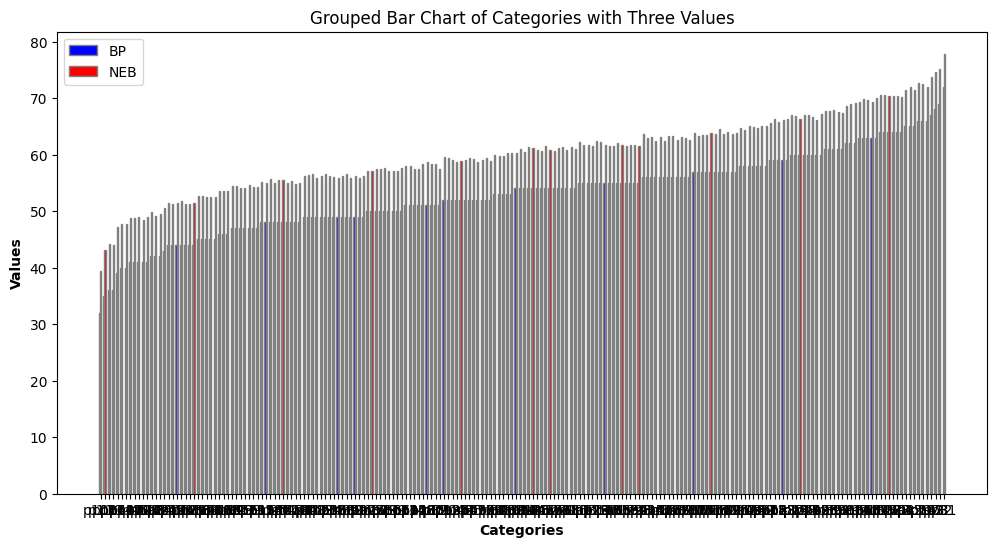

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: list of tuples (category, value1, value2, value3)
data = tmlist

# Extract categories and values from the data
categories, value1, value2 = zip(*data)

# Set the width of the bars
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, value1, color='b', width=bar_width, edgecolor='grey', label='BP')
plt.bar(r2, value2, color='r', width=bar_width, edgecolor='grey', label='NEB')

# Add labels and title
plt.xlabel('Categories', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.title('Grouped Bar Chart of Categories with Three Values')
plt.xticks([r + bar_width for r in range(len(categories))], categories)

# Add legend
plt.legend()

# Display the plot
plt.show()


